# Responsible Data Science Lab 4

In this lab, we will be exploring how data cleaning (or the lack thereof) can impact your analysis. To do so, we will be analyzing data about restaurant health inspections in New York City.

About five years ago, a data analyst uncovered some [concerning trends](https://iquantny.tumblr.com/post/76928412519/think-nyc-restaurant-grading-is-flawed-heres) in the scores that restaurants recieve: scores are far more likely to be just *above* a letter grade cutoff than just below the cutoff. This suggests that inspectors are making decisions to avoid giving establishments a bad letter grade -- with little regard for the health of the customers.

In this lab, we're going to test whether this finding is still true--  and explore other features along with health inspection scores vary.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = [15, 5]

## Step 1: Read in the data

This data was downloaded from [NYC Open Data](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j). There's also more information available on the grading system [here](https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf). 

Take a minute to read the documentation before we dive in. 

In [3]:
instructor_path = "../../shared/Lab 4/DOHMH_New_York_City_Restaurant_Inspection_Results.csv"
student_path = "../shared/Lab 4/DOHMH_New_York_City_Restaurant_Inspection_Results.csv"
inspections = pd.read_csv(instructor_path)

In [4]:
print(inspections.columns)
print(inspections.dtypes)
inspections.head()

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA'],
      dtype='object')
CAMIS                      int64
DBA                       object
BORO                      object
BUILDING                  object
STREET                    object
ZIPCODE                  float64
PHONE                     object
CUISINE DESCRIPTION       object
INSPECTION DATE           object
ACTION                    object
VIOLATION CODE            object
VIOLATION DESCRIPTION     object
CRITICAL FLAG             object
SCORE                    float64
GRADE                     object
GRADE DATE                object
RECORD DATE               object
INSPECTION TYPE           obj

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,41025692,IL PICCOLO BUFALO,Manhattan,141,MULBERRY STREET,10013.0,2122199068,Italian,05/15/2017,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,13.0,A,05/15/2017,02/14/2020,Cycle Inspection / Re-inspection,40.718698,-73.997619,102.0,1.0,4100.0,1003079.0,1.002360e+09,MN24
1,50001632,4TH FLOOR CAFE,Manhattan,221,EAST 71ST STREET,10021.0,2125170586,American,04/21/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41º F (smoked fish a...,Y,22.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.768624,-73.960042,108.0,4.0,12600.0,1076309.0,1.014260e+09,MN31
2,41585019,OBAO NOODLES & BBQ,Manhattan,38,WATER STREET,10004.0,2123616313,Thai,02/15/2018,Violations were cited in the following area(s).,02G,Cold food item held above 41º F (smoked fish a...,Y,11.0,A,02/15/2018,02/14/2020,Cycle Inspection / Re-inspection,40.703222,-74.010521,101.0,1.0,900.0,1077806.0,1.000078e+09,MN25
3,50080456,THE RICE NOODLE,Manhattan,190,BLEECKER ST,10012.0,6468959908,Chinese,06/25/2019,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,37.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.729254,-74.001404,102.0,3.0,6500.0,1008302.0,1.005260e+09,MN23
4,50016586,OTTO'S TACOS,Manhattan,131,7TH AVE S,10014.0,6466570646,Mexican,06/05/2019,Violations were cited in the following area(s).,02G,Cold food item held above 41º F (smoked fish a...,Y,16.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.734502,-74.002284,102.0,3.0,7300.0,1010837.0,1.006110e+09,MN23


In [5]:
# Rename the columns to avoid spaces and make everything lower case
inspections.columns = [x.lower().replace(" ", "_") for x in inspections.columns]
print(inspections.columns)

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'cuisine_description', 'inspection_date', 'action', 'violation_code',
       'violation_description', 'critical_flag', 'score', 'grade',
       'grade_date', 'record_date', 'inspection_type', 'latitude', 'longitude',
       'community_board', 'council_district', 'census_tract', 'bin', 'bbl',
       'nta'],
      dtype='object')


Let's see if we can reproduce the chart in that blog post right now!

A quick google will get us the cutoffs for the letter grades from a credible source -- the NYC Health Department. According to [this](https://www1.nyc.gov/site/doh/business/food-operators/letter-grading-for-restaurants.page), the cutoffs are 
- A: 0-13
- B: 14-27
- C: 28+

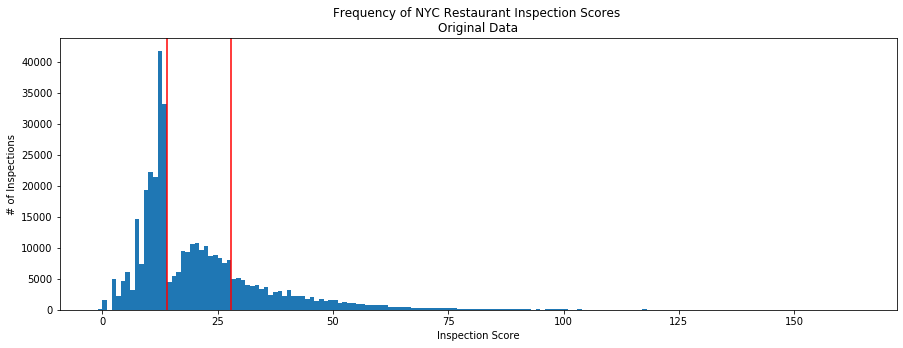

In [6]:
# Let's see if we can reproduce the chart in that blog post right now!
def plot_grades(df, title):
    
    # Plot a histogram
    plt.hist(df['score'], bins=range(int(min(df['score'])), int(max(df['score']))+1) )
    # Add lines to indicate the cutoffs between A and B, then B and C
    plt.axvline(x=14, color="red")
    plt.axvline(x=28, color="red")
    # Add some labels
    plt.ylabel("# of Inspections")
    plt.xlabel("Inspection Score")
    plt.title("Frequency of NYC Restaurant Inspection Scores \n{}".format(title))
    return
    
plot_grades(inspections, "Original Data")


Cool! Are we done? 

What would you say if you saw this chart on the internet?

What would happen if we took this to a reporter or to a public health official? 

## Step 2: Back up and do some profiling

In [7]:
inspections.grade.value_counts()

A    159419
B     25327
C      9417
Z      3187
P      2672
N      2505
G         6
Name: grade, dtype: int64

In [8]:
inspections.score.describe()

count    383708.000000
mean         20.408407
std          14.827808
min          -1.000000
25%          11.000000
50%          15.000000
75%          26.000000
max         164.000000
Name: score, dtype: float64

This brings up some questions that suggest we'll have to deal with when cleaning the data: Why are there negative scores? What do letter grades N and Z mean?

In [9]:
# Do some more profiling here! 

In [10]:
# What are the worst restaurants?
inspections.loc[inspections.score == max(inspections.score)]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
62540,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,164.0,NaN,NaN,02/14/2020,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
63922,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,164.0,NaN,NaN,02/14/2020,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
111647,50061507,BICKLES 2 GO,Bronx,647,COURTLANDT AVE,10451.0,3479634184,Caribbean,05/08/2019,Establishment Closed by DOHMH. Violations wer...,04L,Evidence of mice or live mice present in facil...,Y,164.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.818921,-73.918478,201.0,17.0,6700.0,2001885.0,2.024110e+09,BX34
114747,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,04J,Appropriately scaled metal stem-type thermomet...,Y,164.0,NaN,NaN,02/14/2020,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
118100,50061507,BICKLES 2 GO,Bronx,647,COURTLANDT AVE,10451.0,3479634184,Caribbean,05/08/2019,Establishment Closed by DOHMH. Violations wer...,09B,Thawing procedures improper.,N,164.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.818921,-73.918478,201.0,17.0,6700.0,2001885.0,2.024110e+09,BX34
146829,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,05H,"No facilities available to wash, rinse and san...",Y,164.0,NaN,NaN,02/14/2020,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
151198,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,164.0,NaN,NaN,02/14/2020,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
184283,50099216,RENIX SPORTS BAR,Queens,3764,103RD ST,11368.0,7184576057,American,10/03/2019,Violations were cited in the following area(s).,05D,Hand washing facility not provided in or near ...,Y,164.0,NaN,NaN,02/14/2020,Pre-permit (Non-operational) / Initial Inspection,40.752760,-73.864199,403.0,21.0,40500.0,4044237.0,4.017680e+09,QN26
200628,50061507,BICKLES 2 GO,Bronx,647,COURTLANDT AVE,10451.0,3479634184,Caribbean,05/08/2019,Establishment Closed by DOHMH. Violations wer...,05C,Food contact surface improperly constructed or...,Y,164.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.818921,-73.918478,201.0,17.0,6700.0,2001885.0,2.024110e+09,BX34
210697,50061507,BICKLES 2 GO,Bronx,647,COURTLANDT AVE,10451.0,3479634184,Caribbean,05/08/2019,Establishment Closed by DOHMH. Violations wer...,06C,Food not protected from potential source of co...,Y,164.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.818921,-73.918478,201.0,17.0,6700.0,2001885.0,2.024110e+09,BX34


In [11]:
# Check out one restaraunt in particular
inspections.loc[(inspections.dba == "DOS TOROS TAQUERIA") & (inspections.street == "4 AVENUE"), ]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
20820,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/09/2019,Violations were cited in the following area(s).,08B,Covered garbage receptacle not provided or ina...,N,12.0,A,05/09/2019,02/14/2020,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
22191,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/12/2016,Violations were cited in the following area(s).,15L,Smoke free workplace smoking policy inadequate...,N,NaN,NaN,NaN,02/14/2020,Smoke-Free Air Act / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
27495,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/24/2018,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,6.0,A,05/24/2018,02/14/2020,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
114154,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/09/2019,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,12.0,A,05/09/2019,02/14/2020,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
122142,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/24/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,6.0,A,05/24/2018,02/14/2020,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
144697,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/12/2016,Violations were cited in the following area(s).,15I,"""""No Smoking” and/or 'Smoking Permitted” sign ...",N,NaN,NaN,NaN,02/14/2020,Smoke-Free Air Act / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
159011,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,06/20/2017,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment...,Y,13.0,A,06/20/2017,02/14/2020,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
220155,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/09/2019,Violations were cited in the following area(s).,02I,Food prepared from ingredients at ambient temp...,Y,12.0,A,05/09/2019,02/14/2020,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
295273,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,05/24/2018,Violations were cited in the following area(s).,10I,"Single service item reused, improperly stored,...",N,6.0,A,05/24/2018,02/14/2020,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22
305170,41445110,DOS TOROS TAQUERIA,Manhattan,137,4 AVENUE,10003.0,2126777300,Mexican,06/20/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41º F (smoked fish a...,Y,13.0,A,06/20/2017,02/14/2020,Cycle Inspection / Initial Inspection,40.733656,-73.989864,103.0,2.0,4200.0,1077569.0,1.005590e+09,MN22


Are there any features that might have a functional dependency, or even redundancy? Let's test it.

In [12]:
def test_dependency(df, col1, col2):
    '''Tests whether there is total redundancy betwen col1 and col2
       by testing the number of unique combinations'''
    unique_1 = len(df[col1].unique())
    unique_2 = len(df[col2].unique())
    unique_combos = len(df[[col1, col2]].drop_duplicates())
    print("Unique values of {}: {}".format(col1, unique_1))
    print("Unique values of {}: {}".format(col2, unique_2))
    print("Unique combos of {} and {}: {}".format(col1, col2, unique_combos))
    return unique_combos == max(unique_1, unique_2)

In [13]:
# Fill in some variables that you think might have functional dependencies
test_dependency(inspections, '', '')

Unique values of violation_code: 106
Unique values of violation_description: 91
Unique combos of violation_code and violation_description: 106


True

## Step 3: Find a unique identifier 

Let's start with CAMIS, because the documentation told us that it's a unique identifier for each restaurant. Is it a unique identifier for the dataset?

In [14]:
# Your code here

Wow, we don't even know what "level" the data is at right now. Let's figure out what we *can* use as a unique identifier. 

In [15]:
# First, is this even possible? Are the rows of our data unique?
print("# of duplicates: ", sum(inspections.duplicated()))

# No -- so let's drop these duplicates
inspections = inspections.loc[~inspections.duplicated(), ]

# Now we can search for a unique identifier

# of duplicates:  7


In [16]:
# Test if these variables are a unique identifier
possible_identifier = ['', '']
print("# of duplicates: ",sum(inspections.duplicated(possible_identifier)))

# Show some duplicates
inspections.sort_values(possible_identifier, axis=0, inplace=True)
inspections.loc[inspections.duplicated(possible_identifier, keep=False), ].head(10)


# of duplicates:  0


,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta


Without a domain expert right at handm, we can't resolve some of these duplicates for the purposes of our analysis. Because the total number is small, we can drop them. However, the appropriateness of dropping duplicates will vary from case to case. 

Can anyone think of an example where it would be inappropriate to drop duplicates?

In [17]:
# Drop the duplicates we can't resolve 
unique_id =  ['camis', 'inspection_date', 'violation_code', 'inspection_type']
inspections = inspections.loc[~inspections.duplicated(unique_id), ]
assert sum(inspections.duplicated(unique_id)==0)

That's probably not the level we want to do our analysis at, though: we want one record for every inspection of every restaurant, because that's the level at which grades get assigned. (For example, you don't get a letter grade for not having roaches -- you get a letter grade for the total of all the violations)

Do we really want the data at this level though? 

Let's try to understand more about inspection types.

In [18]:
inspections.inspection_type.value_counts()

Cycle Inspection / Initial Inspection                          234157
Cycle Inspection / Re-inspection                                96328
Pre-permit (Operational) / Initial Inspection                   28284
Pre-permit (Operational) / Re-inspection                        12247
Administrative Miscellaneous / Initial Inspection                7303
Cycle Inspection / Reopening Inspection                          4479
Pre-permit (Non-operational) / Initial Inspection                3496
Smoke-Free Air Act / Initial Inspection                          2069
Administrative Miscellaneous / Re-inspection                     2026
Trans Fat / Initial Inspection                                   1559
Pre-permit (Operational) / Compliance Inspection                 1278
Calorie Posting / Initial Inspection                             1230
Inter-Agency Task Force / Initial Inspection                     1101
Pre-permit (Operational) / Reopening Inspection                  1101
Cycle Inspection / C

In [19]:
# Are all of these inspections similar with respect to the things we care about?
# That is, do all inspeciton types end with a grade that gets posted out on the window?
inspections.loc[inspections.grade.notna(), "inspection_type"].value_counts()

Cycle Inspection / Re-inspection                        92860
Cycle Inspection / Initial Inspection                   83164
Pre-permit (Operational) / Re-inspection                11668
Pre-permit (Operational) / Initial Inspection           10095
Cycle Inspection / Reopening Inspection                  3515
Pre-permit (Operational) / Reopening Inspection           648
Pre-permit (Non-operational) / Initial Inspection         471
Pre-permit (Non-operational) / Re-inspection               73
Inter-Agency Task Force / Initial Inspection               15
Smoke-Free Air Act / Initial Inspection                    11
Pre-permit (Non-operational) / Compliance Inspection        8
Pre-permit (Operational) / Compliance Inspection            5
Name: inspection_type, dtype: int64

Based on this information, let's make a judgement call: our analysis will only be based on cycle inspections.

We will have to be sure to mention this whenever we are presenting our results.

In [20]:
inspections = inspections.loc[inspections.inspection_type.isin(["Cycle Inspection / Re-inspection", "Cycle Inspection / Initial Inspection"]), ] 

In [21]:
# Let's see if we still need inspection_type to uniquely identify the data
unique_id =  ['camis', 'inspection_date', 'violation_code']
assert sum(inspections.duplicated(unique_id)==0)


Great! Now we know that our data has one record per violation that was discovered at a given restaurant on a given date. 

Should we just keep one record per restaurant per inspection date arbitrarily?

In [22]:
# Test whether we'll lose other information
# if we drop duplicates 
unique_id = ['camis', 'inspection_date']
columns_not_dropped = list(inspections.columns)
columns_not_dropped.remove('violation_code')
columns_not_dropped.remove('violation_description')
print("Unique rows if we drop everything at the violation level: ", len(inspections.loc[~inspections.duplicated(columns_not_dropped), ]))
print("Unique rows if we arbitrarily keep rows that are unique in terms of camis and inspeciton date: ", len(inspections.loc[~inspections.duplicated(unique_id), ]))


Unique rows if we drop everything at the violation level:  112471
Unique rows if we arbitrarily keep rows that are unique in terms of camis and inspeciton date:  112470


We won't actually drop the violations data for now, in case we need it later -- but it's nice to know that we *can* drop it when we're ready to do our analysis. Now we've know how to get one record per cycle inspection per restaurant, AND we know a lot more about our dataset.

Let's check back in with the plot we wanted to make -- if we were to do the analysis after the cleaning we've done so far, has it changed at all from our original attempt?

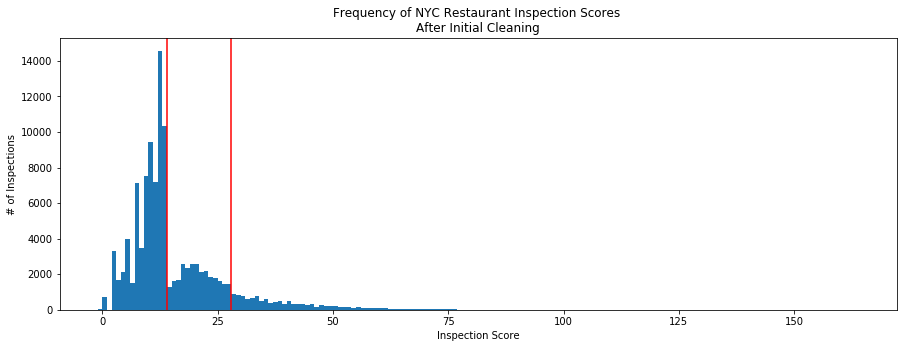

In [23]:
plot_grades(inspections.loc[~inspections.duplicated(unique_id), ], "After Initial Cleaning")

## Step 4: Deep dive into the grades and scores

Recall from earlier that we had grades of N and Z. Can you do some googling and figure out what those are?

Next, let's look at the relationship between grades and scores, and see if it matches what we found on the Department of Health website. As a reminder, the cutoffs should be:

- A: 0-13
- B: 14-27
- C: 28+

In [24]:
inspections.groupby(["grade"]).agg({'score': [np.min,np.max]})

score       
       amin   amax
grade             
A       0.0   23.0
B      -1.0   32.0
C      -1.0   98.0
N       0.0  119.0
Z      14.0   65.0

That doesn't look right. Let's look at some actual cases that appear miscoded.

In [25]:
# Cases with a score too high to be assigned an "A" that are marked as an "A"
inspections.sort_values(unique_id, axis=0, inplace=True)
inspections.loc[(inspections.grade=="A") & (inspections.score > 13), ].head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
73890,40399329,ARTE RESTAURANT,Manhattan,21,EAST 9 STREET,10003.0,2124730077,Italian,10/15/2019,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Y,23.0,A,10/15/2019,02/14/2020,Cycle Inspection / Re-inspection,40.732347,-73.994725,102.0,2.0,5900.0,1009240.0,1.005670e+09,MN23
54083,40711301,CHICKEN FESTIVAL,Queens,2919,DITMARS BOULEVARD,11105.0,7187289696,Chicken,03/14/2018,Violations were cited in the following area(s).,04A,Food Protection Certificate not held by superv...,Y,14.0,A,03/14/2018,02/14/2020,Cycle Inspection / Re-inspection,40.776718,-73.911525,401.0,22.0,11300.0,4017714.0,4.008460e+09,QN72
178618,40711301,CHICKEN FESTIVAL,Queens,2919,DITMARS BOULEVARD,11105.0,7187289696,Chicken,03/14/2018,Violations were cited in the following area(s).,08C,Pesticide use not in accordance with label or ...,N,14.0,A,03/14/2018,02/14/2020,Cycle Inspection / Re-inspection,40.776718,-73.911525,401.0,22.0,11300.0,4017714.0,4.008460e+09,QN72
57673,40711301,CHICKEN FESTIVAL,Queens,2919,DITMARS BOULEVARD,11105.0,7187289696,Chicken,03/14/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,N,14.0,A,03/14/2018,02/14/2020,Cycle Inspection / Re-inspection,40.776718,-73.911525,401.0,22.0,11300.0,4017714.0,4.008460e+09,QN72
308592,41021991,EXTRA VIRGIN,Manhattan,259,WEST 4 STREET,10014.0,2126919359,Mediterranean,05/09/2018,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,21.0,A,05/09/2018,02/14/2020,Cycle Inspection / Re-inspection,40.735287,-74.003258,102.0,3.0,7300.0,1010860.0,1.006128e+09,MN23


In [26]:
# Cases with a negative score
inspections.loc[inspections.score < 0, ]

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
105838,40366879,LA FUSTA RESTAURANT,Queens,8032,BAXTER AVENUE,11373.0,7184298222,"Latin (Cuban, Dominican, Puerto Rican, South &...",03/14/2018,Violations were cited in the following area(s).,06B,"Tobacco use, eating, or drinking from open con...",Y,-1.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.744707,-73.884570,404.0,25.0,26902.0,4000000.0,4.015080e+09,QN29
234202,40366879,LA FUSTA RESTAURANT,Queens,8032,BAXTER AVENUE,11373.0,7184298222,"Latin (Cuban, Dominican, Puerto Rican, South &...",03/14/2018,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,-1.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.744707,-73.884570,404.0,25.0,26902.0,4000000.0,4.015080e+09,QN29
115829,40376515,AMERICAN MUSEUM OF NATURAL HISTORY FOOD COURT,Manhattan,NaN,W 79 STREET,10024.0,2127695370,American,06/05/2019,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,-1.0,C,06/05/2019,02/14/2020,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335562,40376515,AMERICAN MUSEUM OF NATURAL HISTORY FOOD COURT,Manhattan,NaN,W 79 STREET,10024.0,2127695370,American,06/05/2019,Violations were cited in the following area(s).,02G,Cold food item held above 41º F (smoked fish a...,Y,-1.0,C,06/05/2019,02/14/2020,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96166,40376515,AMERICAN MUSEUM OF NATURAL HISTORY FOOD COURT,Manhattan,NaN,W 79 STREET,10024.0,2127695370,American,06/05/2019,Violations were cited in the following area(s).,04H,"Raw, cooked or prepared food is adulterated, c...",Y,-1.0,C,06/05/2019,02/14/2020,Cycle Inspection / Re-inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37544,50070804,PITA PAN,Queens,3715,30TH AVE,11103.0,7182041633,Greek,05/06/2019,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,-1.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.764549,-73.916382,401.0,22.0,6502.0,4010728.0,4.006610e+09,QN70
202233,50074298,TSURUTONTAN UDON NOODLE BRASSERIE,Manhattan,64,W 48TH ST,10036.0,2124638219,Japanese,09/12/2019,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,-1.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.758232,-73.980396,105.0,4.0,9600.0,1034501.0,1.012630e+09,MN17
162523,50074298,TSURUTONTAN UDON NOODLE BRASSERIE,Manhattan,64,W 48TH ST,10036.0,2124638219,Japanese,09/12/2019,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Y,-1.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.758232,-73.980396,105.0,4.0,9600.0,1034501.0,1.012630e+09,MN17
246887,50074298,TSURUTONTAN UDON NOODLE BRASSERIE,Manhattan,64,W 48TH ST,10036.0,2124638219,Japanese,09/12/2019,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,-1.0,NaN,NaN,02/14/2020,Cycle Inspection / Initial Inspection,40.758232,-73.980396,105.0,4.0,9600.0,1034501.0,1.012630e+09,MN17


It's time to make a judgement call. Here are the options:

1. Trust the grades in the dataset, and ignore the inconsistent scores. 
2. Trust the scores in the dataset, and resassign new grades based on the scores. 
3. Trust the list of violations, and try to reconstruct the grades and the scores.
4. Trust nothing, and drop all the cases with inconsistencies. 

Which would you do? What additional information would you want before deciding?

In [27]:
# If we're not going to use the violations, we can go ahead and collapse our data to the restaurant-inspection level
inspections = inspections.loc[~inspections.duplicated(unique_id), ]

In [28]:
# Drop cases with impossible scores (-1)
inspections = inspections.loc[inspections.score > 0, ]

In [29]:
# Count miscoded cases
print("Miscoded As: ", len(inspections.loc[(inspections.grade=="A") & (inspections.score > 13), ]))
print("Miscoded Bs: ", len(inspections.loc[(inspections.grade=="B") & ((inspections.score < 14) | (inspections.score > 27))]))
print("Miscoded Cs: ", len(inspections.loc[(inspections.grade=="C") & (inspections.score < 28), ]))
print("Total Graded Cases: ", len(inspections.loc[inspections.grade.isin(["A", "B", "C"])]))

Miscoded As:  6
Miscoded Bs:  9
Miscoded Cs:  3
Total Graded Cases:  73047


In [30]:
# Drop miscoded cases
inspections = inspections.loc[~((inspections.grade=="A") & (inspections.score > 13)), ]
inspections = inspections.loc[~((inspections.grade=="B") & (inspections.score < 14)), ]
inspections = inspections.loc[~((inspections.grade=="B") & (inspections.score > 27)), ]
inspections = inspections.loc[~((inspections.grade=="C") & (inspections.score < 28)), ]

Now, we should check out cases with missing grades. 

In [31]:
print("Cases with missing grades: ", len(inspections.loc[inspections.grade.isna(), ]))
print("Score distribution for cases with missing grades: ", inspections.loc[inspections.grade.isna(), ].score.describe())

Cases with missing grades:  38138
Score distribution for cases with missing grades:  count    38138.000000
mean        24.169096
std         12.994571
min          2.000000
25%         16.000000
50%         21.000000
75%         29.000000
max        164.000000
Name: score, dtype: float64


We aren't actually using the grades for our analysis, and the missingness has meaning, so we can leave these missing values as-is. Sometimes missing data *shouldn't* be imputed!

Time to revisit our plot again.

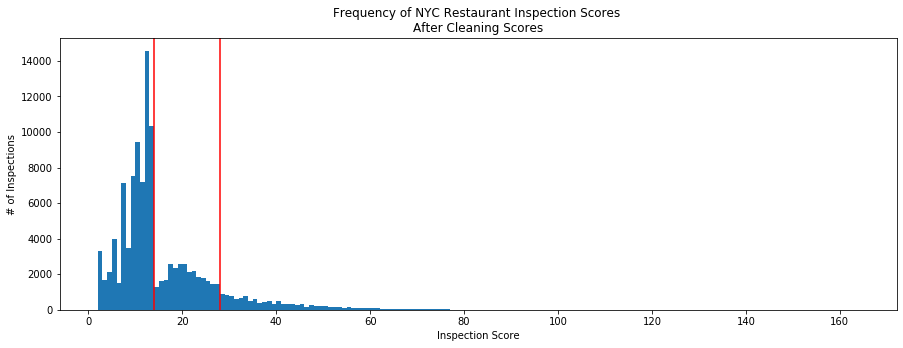

In [32]:
plot_grades(inspections.loc[~inspections.duplicated(unique_id), ], "After Cleaning Scores")

Now, our original question is whether this tendency to bump up borderline cases has gotten better or worse over time. We can analyze that using the inspection_date column.... but first we have to clean it.

In [33]:
# Check the current type of the date column
print("Data type: ", inspections.inspection_date.dtype)
inspections.inspection_date.head(10)

Data type:  object


285571    05/11/2018
338172    05/16/2019
399980    05/18/2017
10369     06/11/2019
346627    10/21/2019
327705    11/04/2019
358977    03/04/2019
39991     03/13/2018
326852    04/30/2016
181317    06/26/2017
Name: inspection_date, dtype: object

In [34]:
inspections.inspection_date = pd.to_datetime(inspections.inspection_date)
inspections.inspection_date.head(10)

285571   2018-05-11
338172   2019-05-16
399980   2017-05-18
10369    2019-06-11
346627   2019-10-21
327705   2019-11-04
358977   2019-03-04
39991    2018-03-13
326852   2016-04-30
181317   2017-06-26
Name: inspection_date, dtype: datetime64[ns]

In [35]:
inspections['year'] = inspections.inspection_date.dt.year
inspections.year.value_counts()

2019    41404
2018    34784
2017    23688
2016     6916
2020     4846
2015       39
2014        4
Name: year, dtype: int64

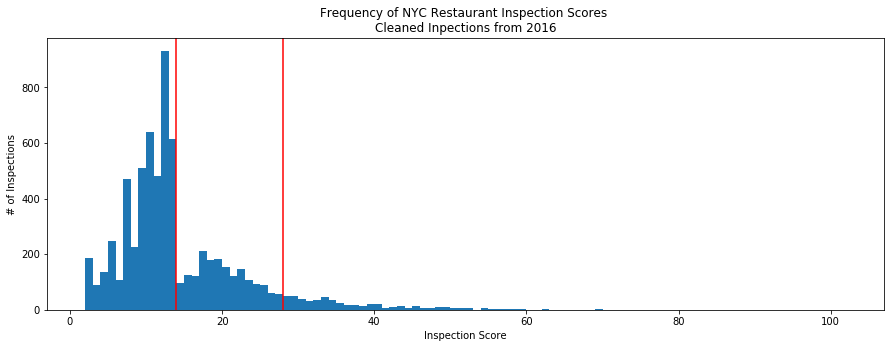

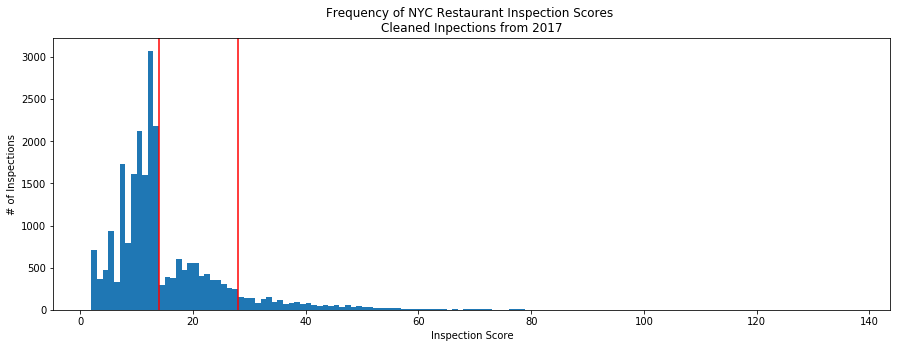

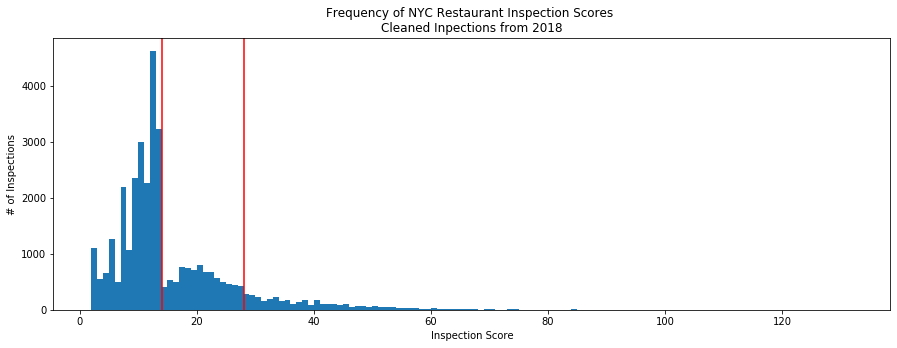

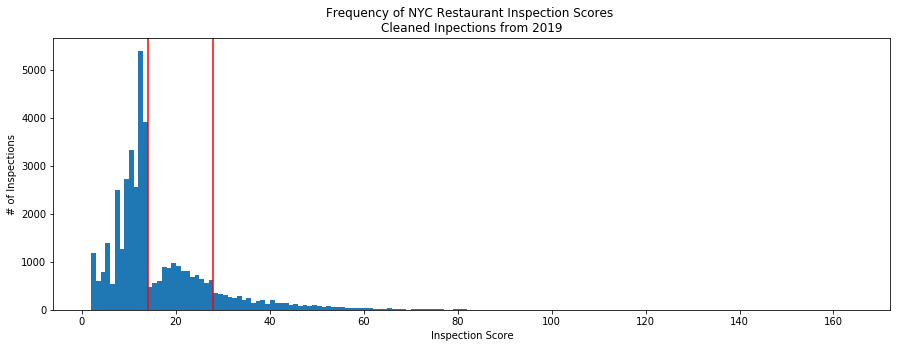

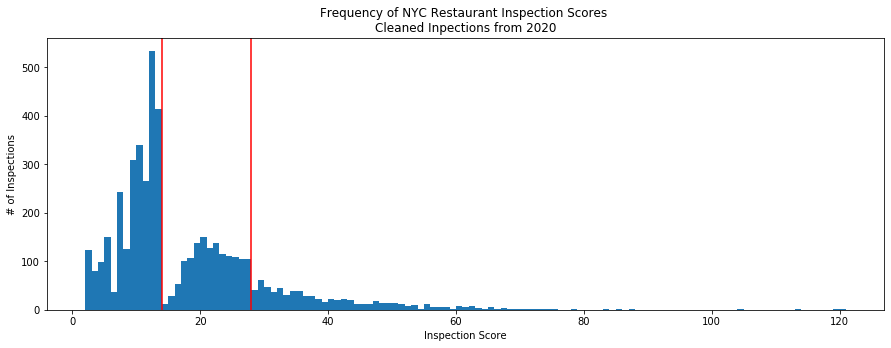

In [36]:
for year in range(2016, 2021):
    plot_grades(inspections.loc[inspections.year==year, ], "Cleaned Inpections from {}".format(year))
    plt.show()

## Step 5: Analysis by borough 

Let's compare the distribution of scores by borough. First, we should check to see if borough was coded correctly. We know that there should be a functional dependency between zipcode and borough, and we can test for violations of that dependency. 

Note that this approach means that we're trusting the zip code column more than the borough column. 

In [37]:
test_dependency(inspections, 'zipcode', 'boro')

Unique values of zipcode: 223
Unique values of boro: 6
Unique combos of zipcode and boro: 229


False

To resolve the violations, we should check for cases where one zipcode corresponds to multiple boroughs. (The relationship between zipcodes and boroughs should be many to one.)

In [38]:
zip_boro_crosswalk = inspections[['zipcode', 'boro']].drop_duplicates()
zip_boro_crosswalk.sort_values('zipcode', inplace=True)
zip_boro_crosswalk.loc[zip_boro_crosswalk.duplicated('zipcode', keep=False), ]

,zipcode,boro
266789,10168.0,0
99134,10168.0,Manhattan
182980,11249.0,0
3434,11249.0,Brooklyn
387627,NaN,Manhattan
263929,NaN,Queens
132631,NaN,Staten Island
271442,NaN,Bronx
261287,NaN,Brooklyn


The cases miscoded as zero are an easy fix. 

The rest of the cases are missing zip codes. Since we're doing our analysis by borough and not by zip code, that's fine for our purposes.

In [39]:
# Recode miscoded zip codes
inspections.loc[inspections.zipcode == 10168, "boro"] = "Manhattan"
inspections.loc[inspections.zipcode == 11249, "boro"] = "Brooklyn"

# Re-make the crosswalk now that we've fixed the data
zip_boro_crosswalk = inspections[['zipcode', 'boro']].drop_duplicates()

But just to be on the safe side, let's check against a ground truth source: a list of zip codes by borough.

In [40]:
instructor_path = "../../shared/Lab 4/zip_borough.csv"
student_path = "../shared/Lab 4/zip_borough.csv"
true_zip_boro_crosswalk = pd.read_csv(instructor_path)
true_zip_boro_crosswalk = true_zip_boro_crosswalk.replace("Staten", "Staten Island")
true_zip_boro_crosswalk.head()

,zip,borough
0,10451,Bronx
1,10452,Bronx
2,10453,Bronx
3,10454,Bronx
4,10455,Bronx


In [41]:
# Compare the two crosswalks
merged_crosswalk = zip_boro_crosswalk.merge(true_zip_boro_crosswalk, how="left", left_on="zipcode", right_on="zip")
merged_crosswalk.loc[(merged_crosswalk.boro != merged_crosswalk.borough) & merged_crosswalk.zipcode.notna(), ]

,zipcode,boro,zip,borough
193,10285.0,0,NaN,NaN
204,10000.0,Manhattan,NaN,NaN
220,12345.0,Manhattan,NaN,NaN


There's another that we didn't catch simply by testing for violations! Good thing we checked against a ground truth source.

The other two zip codes appear fake. We should check the address or coordinates of those restaraunts to confirm that they are marked as being in the right borough.

In [42]:
# Recode the remaining zero
inspections.loc[inspections.zipcode == 10285, "boro"] = "Manhattan"

In [43]:
# List the cases with fake zip codes so that we can check the borough by hand
# Your code here

Let's do one final check to make sure that there are no more zeros.

In [44]:
assert (inspections.boro != "0").all()

Now, we're ready to analyze scores by borough!

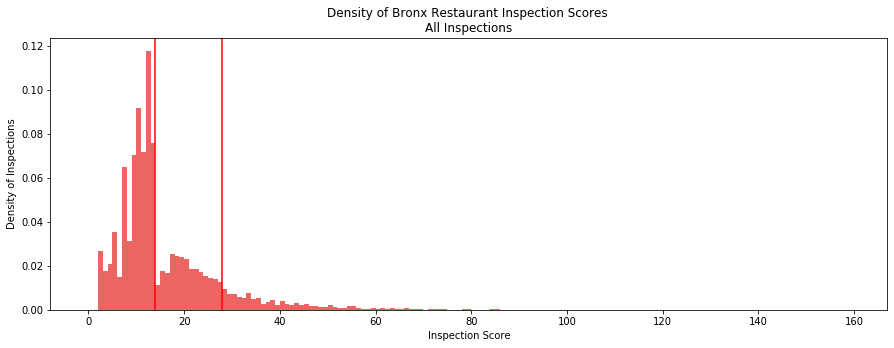

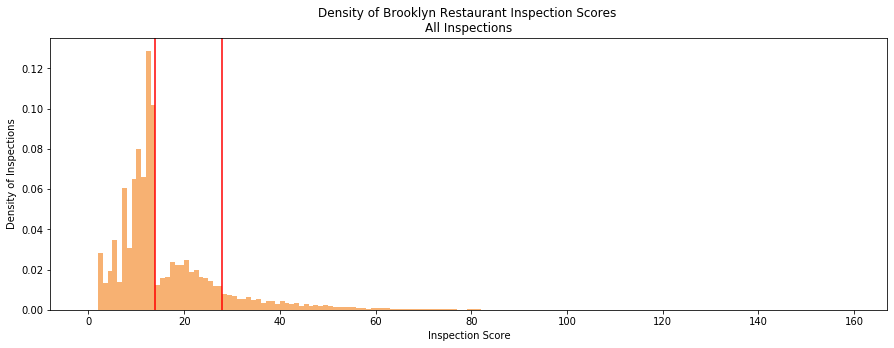

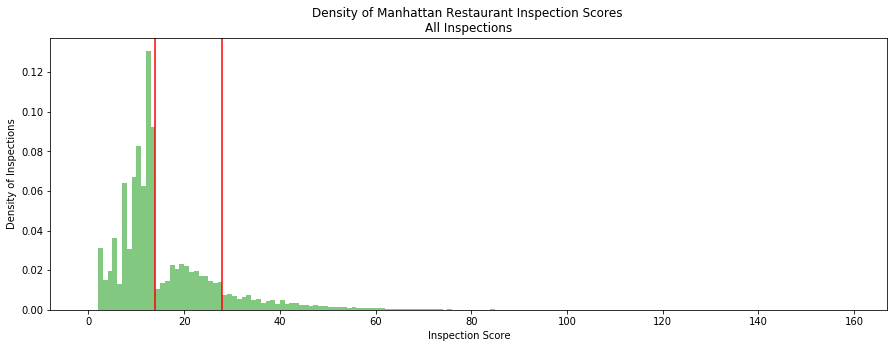

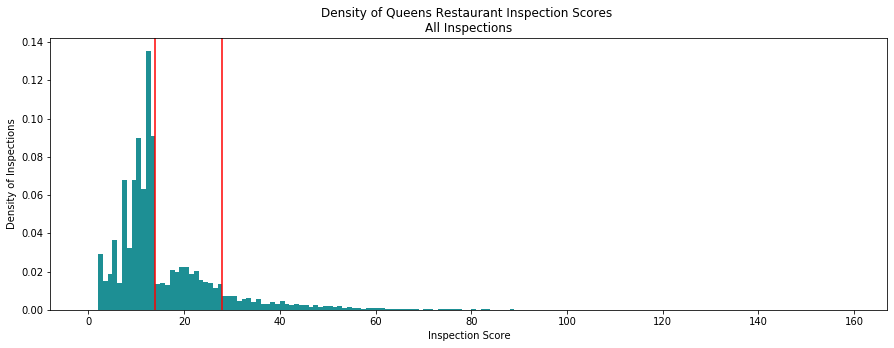

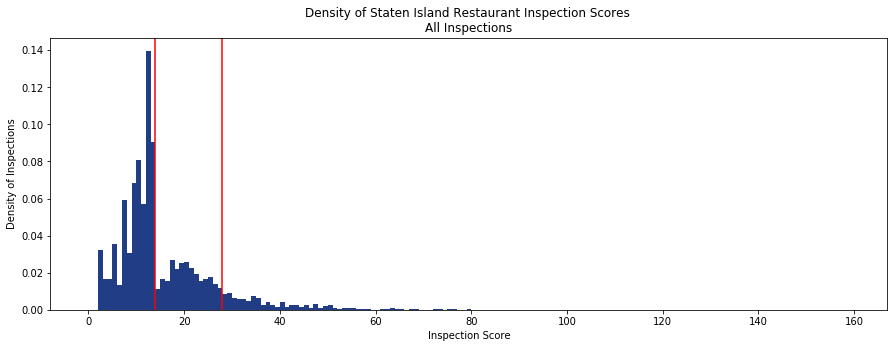

In [45]:
def scores_by_borough(df, title):
    # Plot a histogram for each borough
    boroughs = df.boro.unique()
    colors = ['#EB6662', '#F7B172', "#82C881", "#1D8F94", "#203D85"]
    for i in range(len(boroughs)):
        borough_df = df.loc[df.boro == boroughs[i], ]
        plt.hist(borough_df['score'], density=True, bins=range(0, 160), color=colors[i], label = boroughs[i])
        # Add lines to indicate the cutoffs between A and B, then B and C
        plt.axvline(x=14, color="red")
        plt.axvline(x=28, color="red")
        # Add some labels
        plt.ylabel("Density of Inspections")
        plt.xlabel("Inspection Score")
        plt.title("Density of {} Restaurant Inspection Scores \n{}".format(boroughs[i], title))
        plt.show()
    return
    
scores_by_borough(inspections, "All Inspections")


## Step 6: Analysis of Starbucks

Our analysis above was very general -- each borough is a big and diverse place! (Okay, maybe not Staten Island.)

Instead, we can try looking at chains that have locations in all boroughs; that way, we know that borough is the only thing that varies in the sample. Let's use Starbucks as an example.

In [46]:
# Mark Starbucks
inspections['starbucks'] = inspections.dba=="STARBUCKS"
print("# of Starbucks: \n", inspections.groupby(['boro']).starbucks.sum())

# of Starbucks: 
 boro
Bronx             19.0
Brooklyn         115.0
Manhattan        694.0
Queens           135.0
Staten Island     24.0
Name: starbucks, dtype: float64


In [47]:
# Let's see if we missed anything
inspections.loc[inspections.dba.str.startswith("STAR"), "dba"].value_counts().sort_index()

STAR 99C PIZZA                           8
STAR BILLIARDS                           3
STAR CAFE                                2
STAR CAFE & BAKERY                       3
STAR KABAB & CHINESE RESTAURANT         13
STAR LITE DELI                          11
STAR MOUNTAIN COFFEE                     7
STAR OF SIAM THAI KITCHEN                1
STAR ON 18TH DINER CAFE                  8
STAR PARK                                3
STAR RESTAURANT                          6
STAR'S CAFE (WESTIN HOTEL)               5
STARBUCKS                              987
STARBUCKS # 24485                        3
STARBUCKS #48990                         2
STARBUCKS #50611                         2
STARBUCKS #54446                         1
STARBUCKS #7860                          4
STARBUCKS #847                           5
STARBUCKS (Fordham University)           2
STARBUCKS (Store #50483)                 2
STARBUCKS 379 DEKALB(DESIGN CENTER)      1
STARBUCKS COFFE #55085                   1
STARBUCKS C

In [48]:
inspections['starbucks'] = inspections.dba.str.startswith("STARBUCKS") & (~inspections.dba.str.contains("TAXI"))
print("# of Starbucks: \n", inspections.groupby(['boro']).starbucks.sum())

# of Starbucks: 
 boro
Bronx             28.0
Brooklyn         149.0
Manhattan        840.0
Queens           155.0
Staten Island     29.0
Name: starbucks, dtype: float64


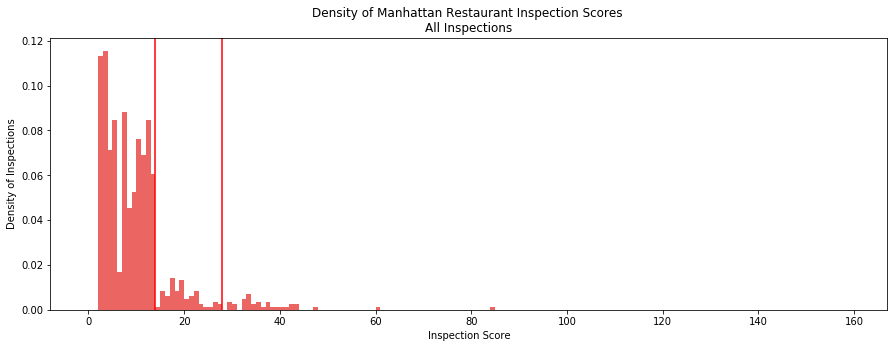

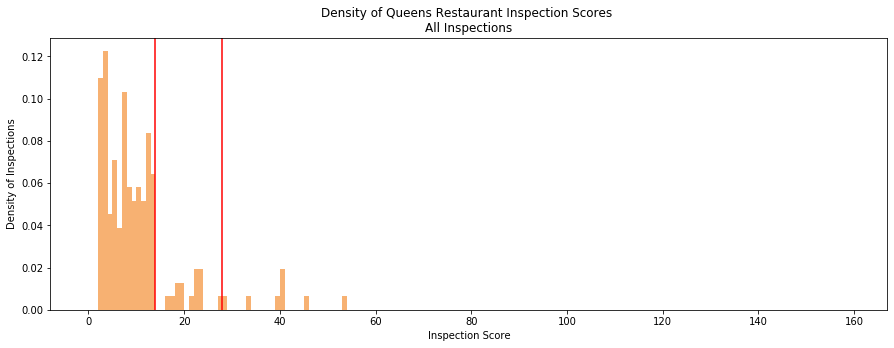

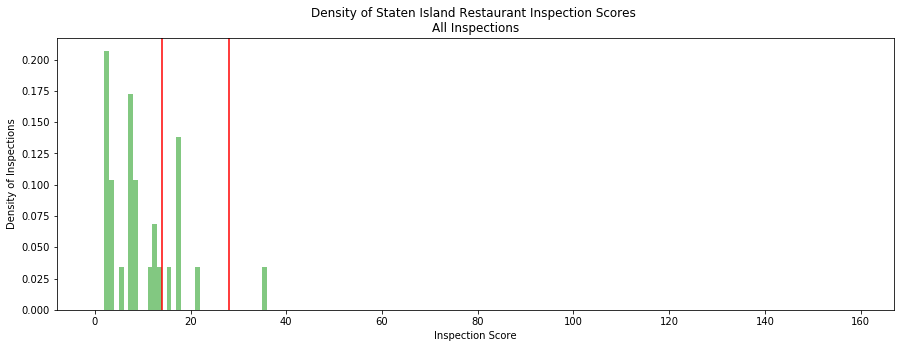

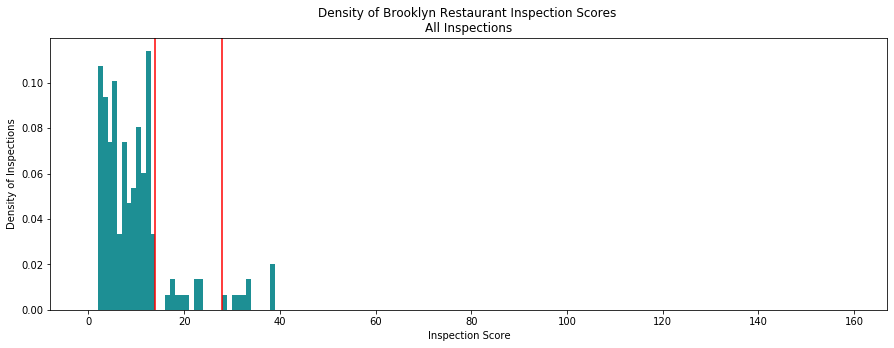

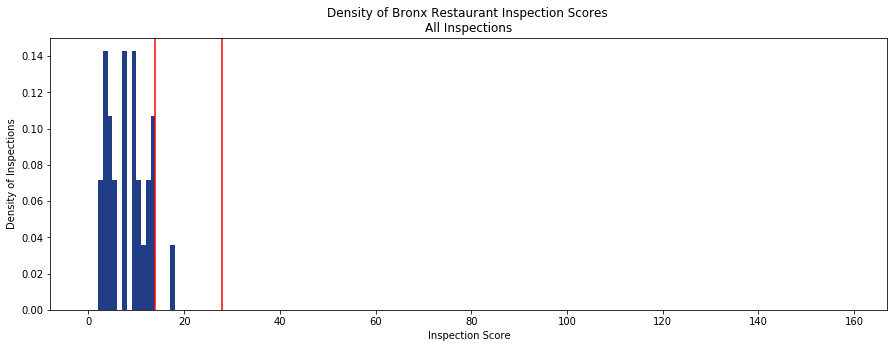

In [49]:
scores_by_borough(inspections.loc[inspections.starbucks, ], "All Inspections")